## Extended Data Figure 11

![title](../assets/EDFig11.png)

In [7]:
%load_ext autoreload
%autoreload 2
import sys
import logging
import itertools
from tqdm import tqdm
from pathlib import Path

sys.path.insert(0, "./prepare_data/")

import yaml
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import Figure4_neurons as neurons
import Figure5_prepare_data as prepare_data5
import Figure6_prepare_data as prepare_data6
import connectome_utils
# import Figure4_graph_tools as graph_tools
# import Figure4_generate_grooming_nets_monosynaptic as gen_network
from common import *

# import plot_utils

DATA_PATH = Path(
    "../data"
)
EXPORT_PATH = Path(
    "../results/EDFigure11"
)
EXPORT_PATH.mkdir(exist_ok=True, parents=True)


FIGSIZE = {'width': 1.2, 'length': 0.9}

# disable matplotlib logger
logging.getLogger("matplotlib.font_manager").disabled = True

plt.style.use('./config.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Panel A: antennal MN4 responses to different input current pairs.

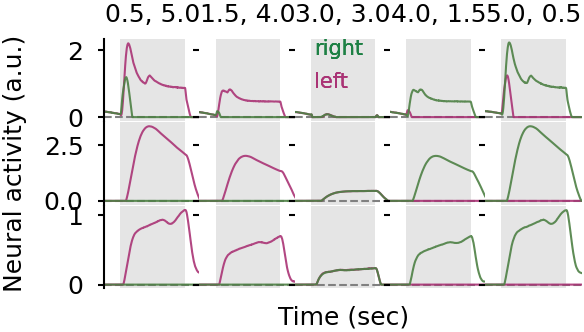

In [8]:
mn4_response = load_data(DATA_PATH / "EDFig11_panelA.pkl")
seed_numbers = [9, 12, 23]
RELU = True

with plt.style.context("./config.mplstyle"):

    current_pairs = [
        (0.5, 5.0),
        (1.5, 4.0),
        (3.0, 3.0),
        (4.0, 1.5),
        (5.0, 0.5),
    ]

    diagonal_ratio = {seed: [] for seed in seed_numbers}
    fig, axs = plt.subplots(
        len(seed_numbers),
        5,
        figsize=(FIGSIZE["width"] * 1.6, FIGSIZE["length"] * 1.2),
        dpi=300,
        sharex="col",
        sharey="row",
    )

    for k, seed in enumerate(seed_numbers):

        count = 0
        for left_current_val, right_current_val in current_pairs:
            voltage_left_mn4, voltage_right_mn4 = mn4_response[seed][
                (left_current_val, right_current_val)
            ]

            if RELU:
                voltage_left_mn4 = relu_function(voltage_left_mn4)
                voltage_right_mn4 = relu_function(voltage_right_mn4)

            axs[k, count].axhline(0, color="grey", linewidth=0.5, linestyle="--")

            axs[k, count].plot(
                voltage_left_mn4,
                color="#AA3375",
                linewidth=0.5,
                alpha=0.9,
                label="left",
            )
            axs[k, count].plot(
                voltage_right_mn4,
                color="#4D8044",
                linewidth=0.5,
                alpha=0.9,
                label="right",
            )

            # span between stim interval
            axs[k, count].axvspan(2500, 4500, color="grey", alpha=0.2, linewidth=0)
            axs[0, count].set_title(
                f"{left_current_val}, {right_current_val}", fontsize=6, y=0.9
            )
            axs[k, count].set_xlim(2000, 5000)
            axs[k, count].set_xticks([2000, 3000, 4000, 5000], labels=[2, 3, 4, 5])
            if count > 0:
                axs[k, count].spines["left"].set_visible(False)
            if k < 3:
                axs[k, count].spines["bottom"].set_visible(False)
                # no x ticks
                axs[k, count].set_xticks([])
            count += 1

        axs[-1, 2].set_xlabel("Time (sec)")
        axs[1, 0].set_ylabel("Neural activity (a.u.)")
        axs[0, 2].text(
            0.2,
            0.8,
            "right",
            transform=axs[0, 2].transAxes,
            fontsize=5,
            color="#1D8044",
        )
        axs[0, 2].text(
            0.2, 0.4, "left", transform=axs[0, 2].transAxes, fontsize=5, color="#AA3375"
        )
    plt.tight_layout(pad=-0.05)
    fig.subplots_adjust(hspace=0.02)
    fig.savefig(
        EXPORT_PATH / f"EDFig11_amn4_resp_{RELU}.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()

## Panel B: heatmaps

In [9]:
normalize_min_max = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

def plot_contour(
    currents,
    area_under_right,
    area_under_left,
    dot_dictionary={},
    title="",
    export_path=None,
    cmap="RdBu_r",
):

    area_under_right_norm = normalize_min_max(area_under_right)
    area_under_left_norm = normalize_min_max(area_under_left)
    area_difference = area_under_left_norm - area_under_right_norm

    fig, ax = plt.subplots(
        figsize=(FIGSIZE["width"] * 1.25, FIGSIZE["length"] * 1.45),
        constrained_layout=True,
    )

    # Setup for first plot
    pcm1 = ax.contourf(
        currents, currents, area_difference, levels=20, cmap=cmap, vmin=-1, vmax=1
    )
    pcm1_c = ax.contour(
        currents,
        currents,
        area_difference,
        levels=20,
        colors=["black"],
        vmin=-1,
        vmax=1,
        alpha=0.5,
    )
    ax.set_xticks(np.arange(currents[0], currents[-1], 1.0))
    ax.set_yticks(np.arange(currents[0], currents[-1], 1.0))
    cbar = fig.colorbar(pcm1, ax=ax, shrink=0.6, pad=0.02, orientation="vertical")
    # Label
    cbar.set_label("aMN activity (a.u.)", rotation=270, labelpad=0.15, fontsize=5)
    # cbar ticks
    cbar.set_ticks([-1, 0, 1])

    for dot_location, dot_color in dot_dictionary.items():
        ax.scatter(*dot_location, marker=".", color=dot_color, s=10)

    ax.set_ylabel("R input (a.u.)")
    ax.set_xlabel("L input (a.u.)")
    ax.set_title(title)

    if export_path is not None:
        plt.savefig(export_path, dpi=300)

    plt.show()

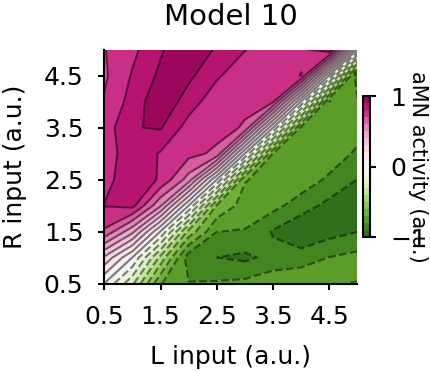

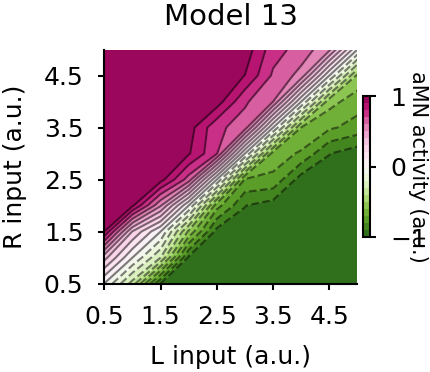

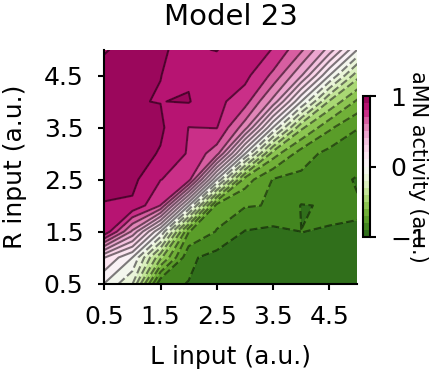

In [10]:
seed2model = {9: 10, 10: 11, 12: 13, 15: 16, 22: 22, 23: 23}

seed_numbers = [9, 12, 23]
current_levels = np.arange(0.5, 5.5, 0.5)

# Due to storage constraints, we skip the processing part and directly take
# the data from the pre-processed data from a pickle file.
heatmap_data = load_data(DATA_PATH / "Fig6_panelC.pkl")


for seed in seed_numbers:
    # data_path_intact = (
    #     lab_server_path
    #     / f"connectome_sym_adj_MLP_decoder_reLu_seed_{seed}/silence_intact"
    # )

    for motor_neuron in ["ANTEN_MN4"]:
        # This function is accessible under prepare_data/Figure6_prepare_data.py
        # area_under_right, area_under_left = calc_area_under_neuron(
        #     current_list=current_levels,
        #     stim_interval=(2500, 4500),
        #     data_path=data_path_intact,
        #     neurons_ordered=neuron_index,
        #     neuron_name=motor_neuron,
        # )

        area_under_left = heatmap_data[seed]["left"]
        area_under_right = heatmap_data[seed]["right"]

        plot_contour(
            current_levels,
            area_under_right,
            area_under_left,
            title=f"Model {seed2model[seed]}",
            cmap="PiYG_r",
            export_path=EXPORT_PATH
            / f"Fig6_panelB_{motor_neuron}_seed{seed}.pdf",
        )

## Panel D: responses of significant neurons

In [11]:
# Load data
cluster2neuron = load_data(DATA_PATH / "cluster2neuron.pkl")
neurons_ordered = list(np.load(DATA_PATH / "neuron_names_ordered.npy"))
asym_input_response = load_data(DATA_PATH / "Fig5_panelF_JO-F_L_5_R_3.pkl")
seed_numbers = [10, 15, 22]

# Significant neurons from neural perturbation screen
neuron_clusters = [
    "ABN1",
    "ABN2",
    "ADN1",
    "cluster_4",
    "cluster_5",
    "cluster_6",
    "cluster_23",
    "cluster_35",
    "cluster_39",
    "cluster_40",
    "cluster_42",
    "cluster_58",
    "cluster_64",
    "12A_DN33",
]

left_neurons = [
    neurons_ordered.index(name + "_L")
    for cluster_name in neuron_clusters
    for i, name in enumerate(cluster2neuron[cluster_name])
]
right_neurons = [
    neurons_ordered.index(name + "_R")
    for cluster_name in neuron_clusters
    for i, name in enumerate(cluster2neuron[cluster_name])
]

neuron_names = [
    neurons_ordered[i][:-2].replace("ANTEN_", "").replace("_", "-") for i in left_neurons
]

imp_neurons_USI = prepare_data5.get_act_difference(
    asym_input_response,
    seed_numbers,
    left_neurons=left_neurons,
    right_neurons=right_neurons,
    start=2500,
    end=4500,
    filter=False
)

/Users/ozdil/Desktop/PhD/Manuscripts/TRIPATITE_2023/antennal-grooming/src/./prepare_data/Figure5_prepare_data.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ratio = (right_area[0] - left_area[0]) / (right_area[0] + left_area[0])


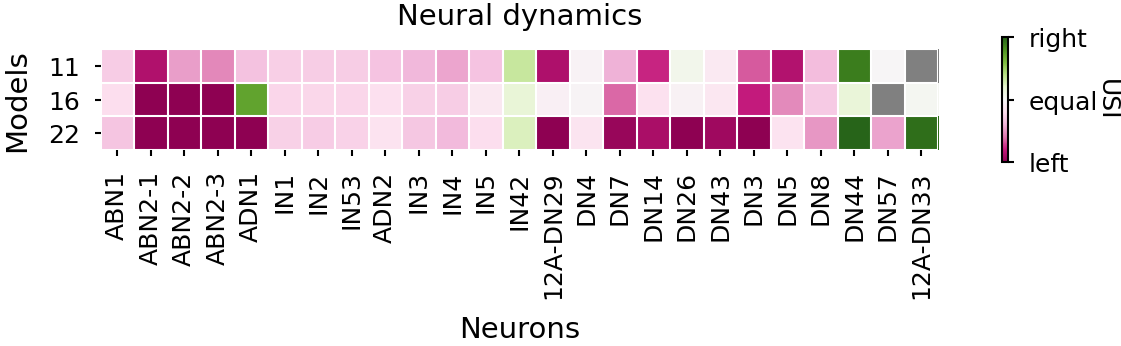

In [12]:
with plt.style.context("./config.mplstyle"):
    fig, ax = plt.subplots(figsize=(FIGSIZE["width"] * 3.8, FIGSIZE["length"] * 2), dpi=300)

    cmap = mpl.colormaps.get_cmap("PiYG")
    cmap.set_bad(color="#808080")

    cax = ax.imshow(imp_neurons_USI, cmap=cmap, aspect=1, vmin=-1, vmax=1)

    # Add grid lines between cells
    ax.set_xticks(np.arange(-0.5, imp_neurons_USI.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, imp_neurons_USI.shape[0], 1), minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", size=0.0)
    ax.grid(False)

    # Add a color bar (legend) for the heatmap
    cbar = fig.colorbar(cax, ax=ax, shrink=0.3, pad=0.06)
    cbar.set_label("USI", rotation=270, labelpad=5)
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(["left", "equal", "right"])

    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.set_yticks(np.arange(len(seed_numbers)), labels=[11,16,22], rotation=0)
    ax.set_ylabel("Models", fontsize=7)
    ax.set_xlabel("Neurons", fontsize=7)
    ax.set_xticks(np.arange(len(neuron_names)), labels=neuron_names, rotation=90)

    ax.set_title(f"Neural dynamics")

    fig.savefig(
        EXPORT_PATH / f"EDFig11_panelD.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()

## Panel E: neural dynamics in the recurrent excitatory network

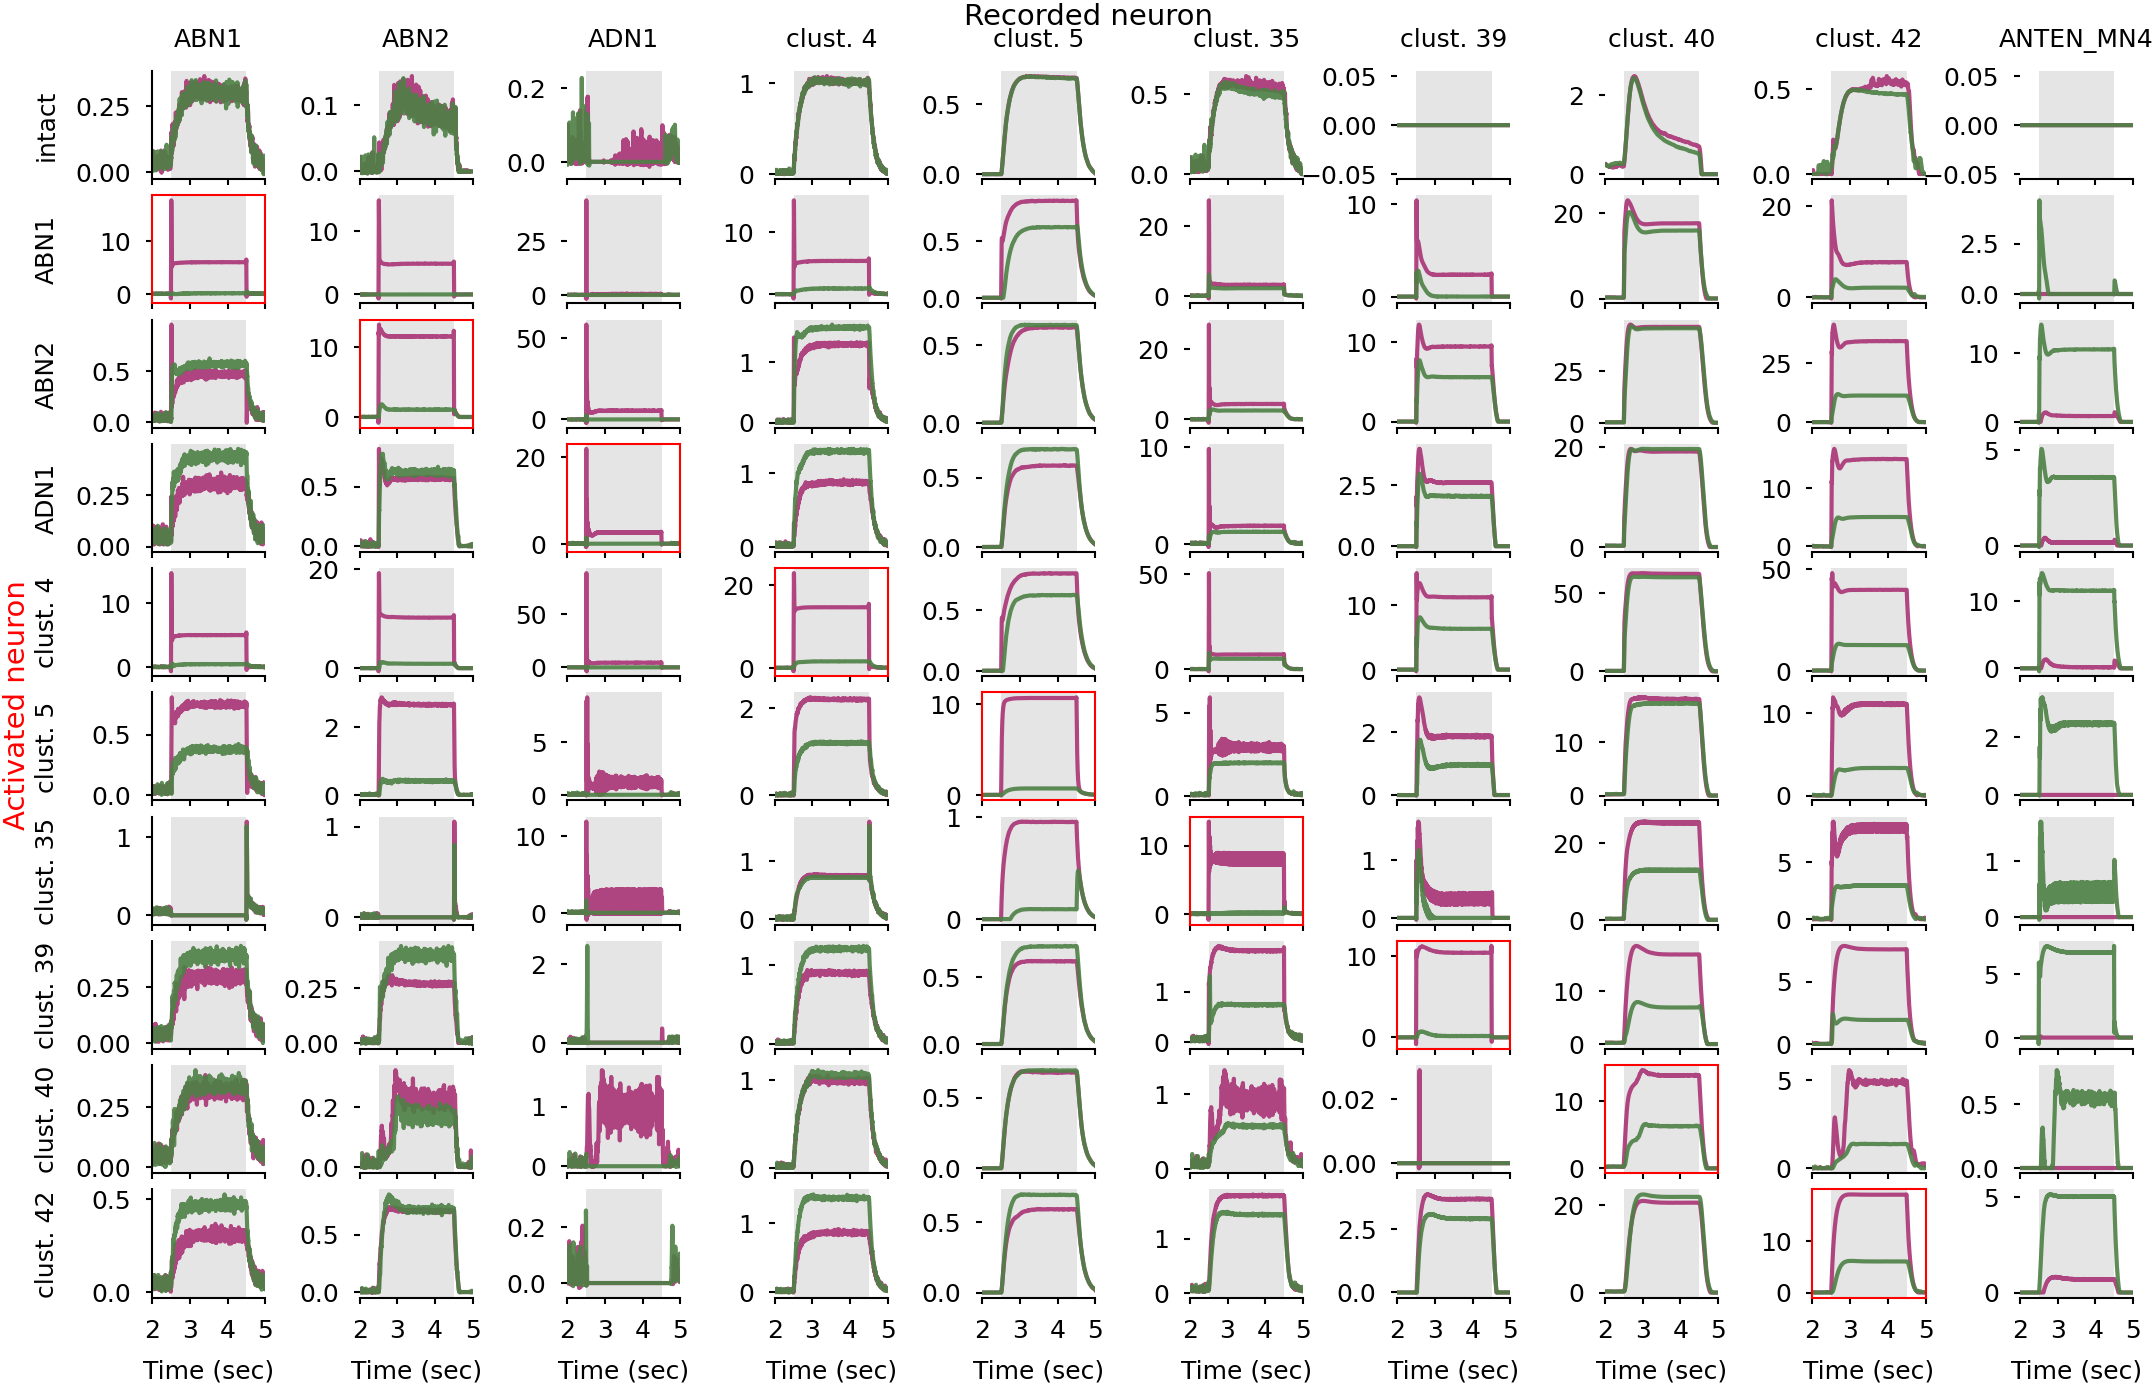

In [13]:
neurons_to_plot = [
    "intact",
    "ABN1",
    "ABN2",
    "ADN1",
    "c_4",
    "c_5",
    "c_35",
    "c_39",
    "c_40",
    "c_42",
    "ANTEN_MN4",
]

neuron_responses = load_data(DATA_PATH / "EDFig11_panelE.pkl")

with plt.style.context("./config.mplstyle"):

    columns = len(neurons_to_plot) - 1
    rows = len(neurons_to_plot) - 1

    fig, axs = plt.subplots(
        rows, columns, figsize=(columns * 0.7, rows * 0.45), dpi=300, sharex=True
    )

    for j, neuron_to_activate in enumerate(neurons_to_plot[:-1]):
        neuron_to_activate = neuron_to_activate.replace("c_", "cluster_")
        for i, neuron_to_plot in enumerate(neurons_to_plot[1:]):
            neurons = cluster2neuron[neuron_to_plot.replace("c_", "cluster_")]
            neuron_idx_l = [neurons_ordered.index(neuron + "_L") for neuron in neurons]
            neuron_idx_r = [neurons_ordered.index(neuron + "_R") for neuron in neurons]

            left_voltage = neuron_responses[neuron_to_activate][neuron_to_plot][0]
            right_voltage = neuron_responses[neuron_to_activate][neuron_to_plot][1]

            mean_left = savgol_filter(np.mean(left_voltage, axis=1), 11, 3)
            mean_right = savgol_filter(np.mean(right_voltage, axis=1), 11, 3)

            axs[j, i].plot(
                mean_left,
                color="#AA3375",
                linewidth=1,
                alpha=0.9,
                label="left",
            )
            # right
            axs[j, i].plot(
                mean_right,
                color="#4D8044",
                linewidth=1,
                alpha=0.9,
                label="right",
            )
            # span between stim interval
            axs[j, i].axvspan(2500, 4500, color="grey", alpha=0.2, linewidth=0)
            axs[0, i].set_title(neuron_to_plot.replace("c_", "clust. "), fontsize=6)
            axs[j, i].set_xlim(2000, 5000)
            axs[-1, i].set_xlabel("Time (sec)")
            axs[j, i].set_xticks([2000, 3000, 4000, 5000], labels=[2, 3, 4, 5])
            if i > 0:
                axs[j, i].spines["left"].set_visible(False)

            if j - i == 1:
                # Frame the axis
                for spine in ["top", "right", "bottom", "left"]:
                    axs[j, i].spines[spine].set_visible(True)
                    axs[j, i].spines[spine].set_color("red")

        axs[j, 0].set_ylabel(
            neuron_to_activate.replace("cluster_", "clust. "), fontsize=6
        )
    fig.text(
        -0.01,
        0.5,
        "Activated neuron",
        ha="center",
        va="center",
        rotation=90,
        fontsize=7,
        color="red",
    )
    fig.text(
        0.5, 1.01, "Recorded neuron", ha="center", va="center", rotation=0, fontsize=7
    )

    fig.align_ylabels(axs)
    plt.tight_layout(pad=-0.1)
    fig.savefig(
        EXPORT_PATH / f"EDFig11_panelE_{seed}.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()

## Panel C, F, G

Note that we modify the graphs aesthetically in Gephi to obtain the publication version.

In [14]:
graph_data = load_data(DATA_PATH / "Fig6_panelH-I.pkl")

MIN_SYN = np.quantile(abs(graph_data['adjacency'][abs(graph_data['adjacency']) > 0]), 0.01)
node2name = graph_data['node2name']
node2pos = graph_data['node2pos']
connectivity = graph_data['edge_df']

0.6454532817006111 0.05483871325850487


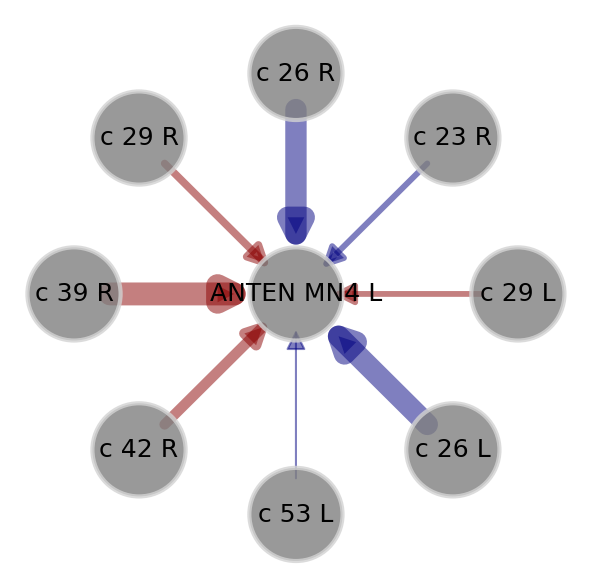

In [15]:
# anten mn 5 node
anten_mn4_node = [
    node for node, name in node2name.items() if "ANTEN_MN4_L" in name["name"]
]
premotor_ids = connectivity[
    connectivity.post_root_id.isin(anten_mn4_node)
].pre_root_id.unique()


def get_flower_pos(center, other_neurons):
    # get the positions of the neurons
    pos = {
        center: (0, 0),
    }
    # get the positions of the other neurons
    for i, neuron in enumerate(other_neurons):
        pos[neuron] = (
            np.cos(2 * np.pi * i / len(other_neurons)),
            np.sin(2 * np.pi * i / len(other_neurons)),
        )
    return pos


for premid in anten_mn4_node:
    sub_network = connectivity[
        (connectivity.pre_root_id == premid) | (connectivity.post_root_id == premid)
    ]
    # Remove rows with weight less than MIN_SYN
    sub_network = sub_network[abs(sub_network.weight) >= MIN_SYN]

    # unique root_ids
    unique_root_ids = (
        set(sub_network.pre_root_id.unique())
        .union(sub_network.post_root_id.unique())
        .difference({premid})
    )

    node2pos_flower = get_flower_pos(premid, unique_root_ids)
    c_name = node2name[premid]["name"].replace("c_", "cluster ").replace("_", " ")

    fig, ax = plt.subplots(
        1, 1, figsize=(FIGSIZE["width"] * 2.1, FIGSIZE["length"] * 2.8)
    )
    network_specs_, subnetwork = connectome_utils.plot_connectivity(
        sub_network,
        node2name,
        # highlight_neuron=node_ids,
        pos=node2pos_flower,
        node_size=500,
        font_size=6,
        synapse_th=0,  # MIN_SYN,
        max_w=5,
        ax=ax,
        layout="circular",
        title="",
        export_path=EXPORT_PATH / f"""EDFig11_panelC_{c_name}.png""",
    )
    # print min max synapse count
    print(np.max(network_specs_["weights"]), np.min(network_specs_["weights"]))

    plt.show()

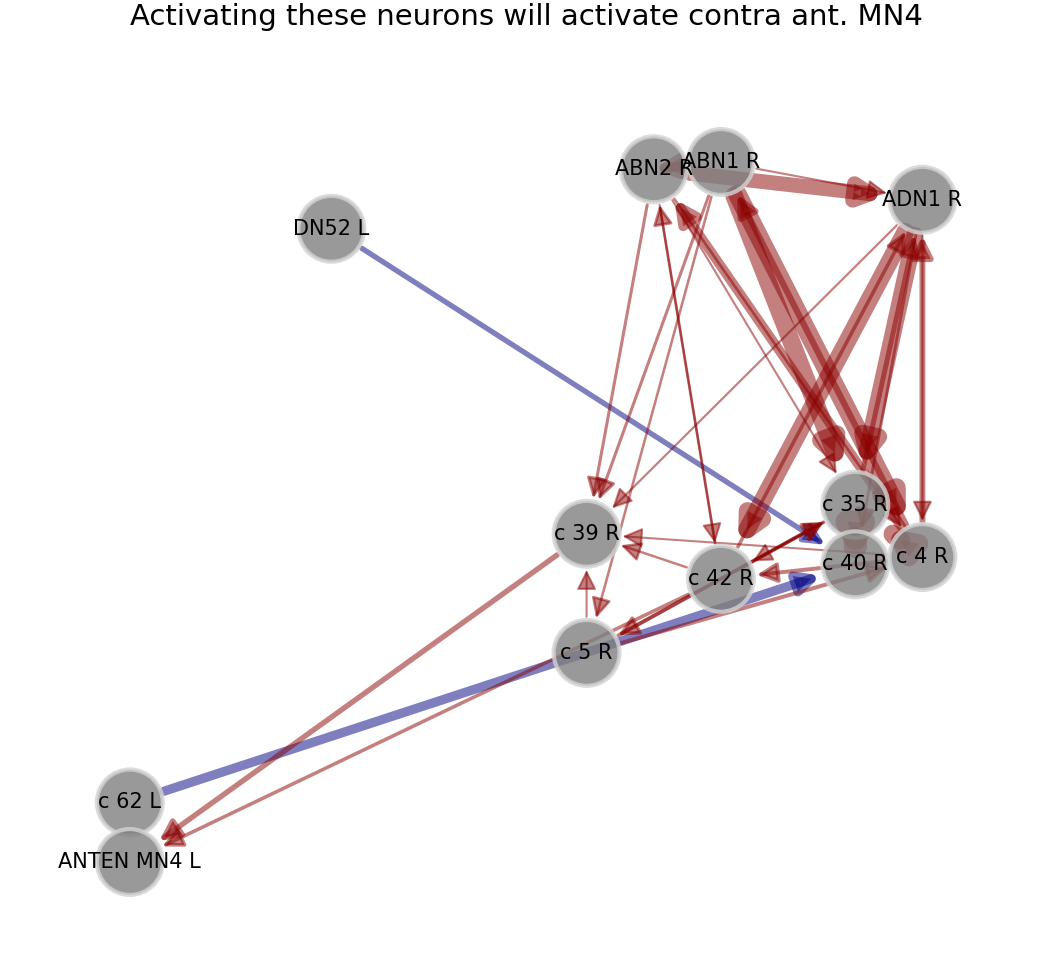

In [16]:
# neurons affecting MN4 results
mn_act_cctry = [
    'DN52_L',
    'c_62_L',
    'ANTEN_MN4_R',
    'ABN1_R',
    'ABN2_R',
    'ADN1_R',
    'DN52_R',
    'c_4_R',
    'c_5_R',
    'c_35_R',
    'c_62_R',
    'c_39_R',
    'c_40_R',
    'c_42_R',
    'ANTEN_MN4_L'
]
node_ids = [
    node_id
    for node_id, neuron_dict in node2name.items()
    if neuron_dict["name"] in mn_act_cctry
]

sub_network = connectivity[
    (connectivity.pre_root_id.isin(node_ids))
    & (connectivity.post_root_id.isin(node_ids))
].reset_index(drop=True)

# Drop weight lowert than MIN_SYN
sub_network = sub_network[abs(sub_network.weight) > MIN_SYN].reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.))
network_specs_motif1, subnetwork_motif1 = connectome_utils.plot_connectivity(
    sub_network,
    node2name,
    pos=node2pos,
    node_size=250,
    font_size=5,
    synapse_th=0,
    max_w=5,
    ax=ax,
    title=f"""Activating these neurons will activate contra ant. MN4""",
    export_path=EXPORT_PATH / """EDFig11_panelF.png""",
)
plt.show()

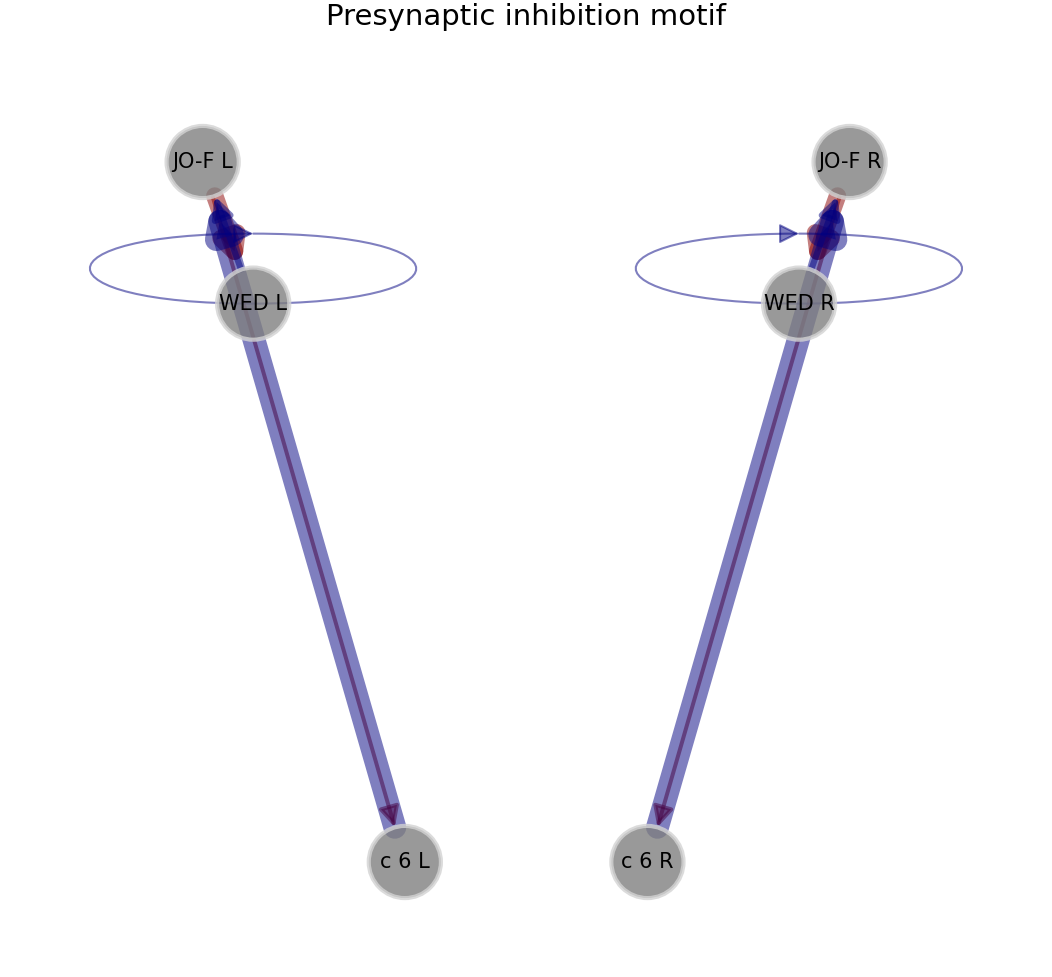

Minimum and maximum weights
0.012913454265799373 3.9876782670617104


In [17]:
# neurons affecting MN4 results
mn_act_cctry = [
    'WED_L',
    'WED_R',
    'c_6_L',
    'c_6_R',
    'JO-F_L',
    'JO-F_R',
]
node_ids = [
    node_id
    for node_id, neuron_dict in node2name.items()
    if neuron_dict["name"] in mn_act_cctry
]

sub_network = connectivity[
    (connectivity.pre_root_id.isin(node_ids))
    & (connectivity.post_root_id.isin(node_ids))
].reset_index(drop=True)
# Drop weight lower than MIN_SYN
sub_network = sub_network[abs(sub_network.weight) > MIN_SYN].reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.))
network_specs_motif2_0, subnetwork_motif2_0 = connectome_utils.plot_connectivity(
    sub_network,
    node2name,
    pos=node2pos,
    node_size=300,
    font_size=5,
    synapse_th=0,
    max_w=5,
    ax=ax,
    title=f"""Presynaptic inhibition motif""",
    export_path=EXPORT_PATH / "EDFig11_panelG.png"
)
plt.show()

print("Minimum and maximum weights")
print(network_specs_motif2_0['weights'].min(),
      network_specs_motif2_0['weights'].max())

## Panel H: presynaptic inhibition

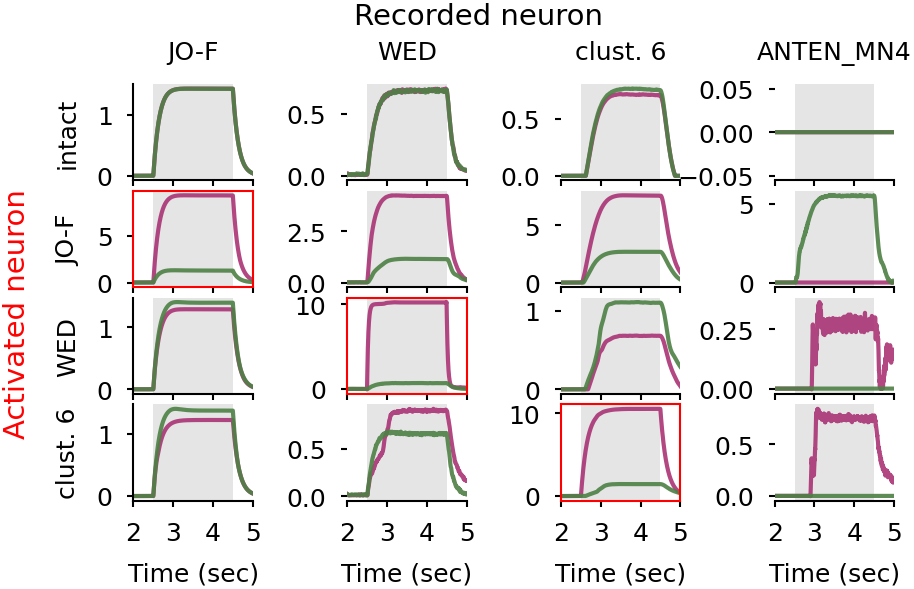

In [18]:
neurons_to_plot = ["intact", "JO-F", "WED", "c_6", "ANTEN_MN4"]

response_pre_inh = load_data(DATA_PATH / "EDFig11_panelH.pkl")

with plt.style.context("./config.mplstyle"):

    columns = len(neurons_to_plot) - 1
    rows = len(neurons_to_plot) - 1

    fig, axs = plt.subplots(
        rows, columns, figsize=(columns * 0.7, rows * 0.45), dpi=300, sharex=True
    )

    for j, neuron_to_activate in enumerate(neurons_to_plot[:-1]):
        neuron_to_activate = neuron_to_activate.replace("c_", "cluster_")
        seed = 22  # looks the best

        for i, neuron_to_plot in enumerate(neurons_to_plot[1:]):
            neurons = cluster2neuron[neuron_to_plot.replace("c_", "cluster_")]
            neuron_idx_l = [neurons_ordered.index(neuron + "_L") for neuron in neurons]
            neuron_idx_r = [neurons_ordered.index(neuron + "_R") for neuron in neurons]

            voltage_left = response_pre_inh[neuron_to_activate][neuron_to_plot][0]
            voltage_right = response_pre_inh[neuron_to_activate][neuron_to_plot][1]

            mean_left = savgol_filter(np.mean(voltage_left, axis=1), 11, 3)
            mean_right = savgol_filter(np.mean(voltage_right, axis=1), 11, 3)

            axs[j, i].plot(
                mean_left,
                color="#AA3375",
                linewidth=1,
                alpha=0.9,
                label="left",
            )

            axs[j, i].plot(
                mean_right,
                color="#4D8044",
                linewidth=1,
                alpha=0.9,
                label="right",
            )

            # span between stim interval
            axs[j, i].axvspan(2500, 4500, color="grey", alpha=0.2, linewidth=0)
            axs[0, i].set_title(neuron_to_plot.replace("c_", "clust. "), fontsize=6)
            axs[j, i].set_xlim(2000, 5000)
            axs[-1, i].set_xlabel("Time (sec)")
            axs[j, i].set_xticks([2000, 3000, 4000, 5000], labels=[2, 3, 4, 5])
            if i > 0:
                axs[j, i].spines["left"].set_visible(False)

            if j - i == 1:
                # Frame the axis
                for spine in ["top", "right", "bottom", "left"]:
                    axs[j, i].spines[spine].set_visible(True)
                    axs[j, i].spines[spine].set_color("red")

        axs[j, 0].set_ylabel(
            neuron_to_activate.replace("cluster_", "clust. "), fontsize=6
        )

    fig.text(
        -0.05,
        0.5,
        "Activated neuron",
        ha="center",
        va="center",
        rotation=90,
        fontsize=7,
        color="red",
    )
    fig.text(
        0.5, 1.05, "Recorded neuron", ha="center", va="center", rotation=0, fontsize=7
    )

    fig.align_ylabels(axs)
    plt.tight_layout(pad=-0.1)
    fig.savefig(
        EXPORT_PATH / f"EDFig11_panelH_presyn_inh_{seed}.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()